In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi")

2022/05/31 11:20:04 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi', tags={}>

In [5]:
df = pd.read_parquet("../data/green_tripdata_2021-01.parquet")

df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df["duration"] = df["duration"].apply(lambda x: x.total_seconds()/60)

import mlflow


In [6]:
df.duration.describe(percentiles = [0.9, 0.95, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
90%         35.000000
95%         44.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [7]:
df = df[(df.duration >= 1) & (df.duration <= 60) ]

In [8]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.827368941909368

c:\Users\Harry\MLOps\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Harry\MLOps\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


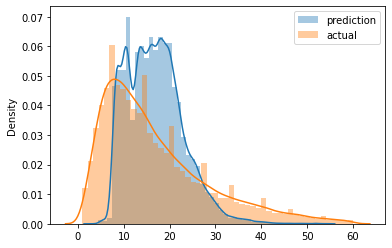

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [14]:
len(df_train), len(df_val)


(73908, 61921)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715208537182

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [20]:
with mlflow.start_run():

    mlflow.set_tag("Developer", "Hitesh")

    mlflow.log_param("train-data-set", '../data/green_tripdata_2021-01.parquet')
    mlflow.log_param("val-data-set", '../data/green_tripdata_2021-02.parquet')
    

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(rmse)

    mlflow.log_metric("rmse",rmse)


12.143233939663894


In [21]:
import xgboost as xgb

In [22]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.set_tag("Developer", "Hitesh")
        
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [26]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[11:27:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:20.09025                          
[1]	validation-rmse:19.06249                          
[2]	validation-rmse:18.10489                          
[3]	validation-rmse:17.21322                          
[4]	validation-rmse:16.38364                          
[5]	validation-rmse:15.61244                          
[6]	validation-rmse:14.89616                          
[7]	validation-rmse:14.23169                          
[8]	validation-rmse:13.61521                          
[9]	validation-rmse:13.04454                          
[10]	validation-rmse:12.51668                         
[11]	validation-rmse:12.02885                         
[12]	validation-rmse:11.57858                         
[13]	validation-rmse:11.16323                         
[14]	validation-rmse:10.78189                        